In [1]:
# importing libraries
import numpy as np                      
import matplotlib.pyplot as plt         
from PIL import Image, ImageOps         
from statistics import mean

In [2]:
# loading the input dataset (data extracted to "dataset1" folder)
input_data = np.array([list(Image.open('Dataset1/s'+str(i+1)+'/'+str(j+1)+'.pgm').convert('L').getdata()) for j in range(10) for i in range(40)])

# Splitting the input dataset(400 images) to training set 60%(240) and testing set 40%(160)
train_set = input_data[:240]
test_set = input_data[240:]

In [3]:
# calculating the mean image of training set
Mean = np.array([mean([p[k] for p in train_set]) for k in range(92*112)])

# calculating mean zero matrix for train_set
mean_cent_train_set = np.array([p - Mean for p in train_set])
# calculating mean zero matrix for test_set                             
mean_cent_test_set = np.array([p - Mean for p in test_set])  

# calculating co-variance matrix
cov_mat = np.matmul(mean_cent_train_set, mean_cent_train_set.T) / len(mean_cent_train_set)                                    
# calculating eigenvalues and eigenvectors
eigen_values, eigen_vectors = np.linalg.eig(cov_mat)  
# sorting the eigenvectors based on eigenvalues
index = eigen_values.argsort()[::-1]
eigen_values = eigen_values[index]
eigen_vectors = eigen_vectors[:, index]

In [4]:
# for storing Accuracy Values of PCA for euc_dist and man_dist
PCA_acc_euc =[]
PCA_acc_man =[]

# for storing Accuracy Values of LDA for euc_dist and man_dist
LDA_acc_euc =[]
LDA_acc_man =[]

# lets take k values between 3 to 27
K = [i for i in range(3, 27)]

# finding Accuracies using 
# 1.PCA and
# 2.LDA

for k in K:
    
    #-----------PCA-----------
    # taking the feature vector based on k value
    feature_vector = eigen_vectors[:, :k]    
    
    # calculating eigen faces of train_set
    eigen_faces = np.matmul(feature_vector.T, mean_cent_train_set )          
    
    # calculating eigen face signatures of train_set
    eigen_signatures = np.matmul(eigen_faces, mean_cent_train_set.T)        
    
    # finding inverse of co-variance matrix
    inv_cov_mat = np.linalg.inv(np.cov(eigen_signatures))

    # to store count of correct predictions using euc_dist and man_dist 
    crct_euc = crct_man = 0
    
    # testing the test_set
    
    for x in range(len(mean_cent_test_set)):
        
        # to store min_euc and min_man distances and its indexes
        min_euc =  min_man = float('inf')
        index_euc = index_man = 0
        
        # test image vector to compare with eigen signatures
        test_img = np.matmul(eigen_faces, mean_cent_test_set[x])
        
        for u in range(len(eigen_signatures[0])):
            req_vect = eigen_signatures[:, u] - test_img
            
            # cal. euc_dist
            euc_dist = np.matmul(req_vect.T , req_vect)
            
            # cal. man_dist
            man_dist = np.matmul(np.matmul(req_vect.T , inv_cov_mat) , req_vect)
            
            # updating min_euc_dist and its index
            if min_euc > euc_dist:                     
                min_euc = euc_dist
                index_euc = u
            
            # updating min_man_dist and its index
            if min_man > man_dist:
                min_man = man_dist
                index_man = u
        
        # updating the crct count if prediction is correct
        if x%40 == index_euc%40: crct_euc += 1
        if x%40 == index_man%40: crct_man += 1
    
    # storing the accuracies for every k
    PCA_acc_euc.append(crct_euc/len(test_set))
    PCA_acc_man.append(crct_man/len(test_set))
    
    

    #---------LDA------------
    
    # calculating the means of each class
    # no of classes = 240/6 = (40) different persons faces
    mean_of_clases = np.array([[mean([eigen_signatures[d][40*j + i] for j in range(6)]) for d in range(k)] for i in range(40)])   #   Means of each class
    
    # cal. total mean of projected faces
    total_mean = np.array([mean([mean_of_clases[i][d] for i in range(40)]) for d in range(k)])
    
    mean_zero_test_set = np.array([[eigen_signatures.T[40*j + i] - mean_of_clases[i] for j in range(6)] for i in range(40)])       #   Zero-centered projected data
    
    # calculating the within scatter matrix
    within_scatter_mat = np.sum([mean_zero_test_set[i].T @ mean_zero_test_set[i] for i in range(40)], 0)                                        #   Within-Class Scatter Matrix

    # calculating the between scatter matrix
    zero_cent_cls_mean = mean_of_clases - np.array([total_mean]*40)                  
    btw_scatter_mat = np.matmul(zero_cent_cls_mean.T, zero_cent_cls_mean)
    
    # calculating the criterion function
    criterion_func = np.matmul(np.linalg.inv(within_scatter_mat), btw_scatter_mat ) 
    
    # calculating the LDA eigenvalues and eigenvectors for criterion func.
    lda_eig_val, lda_eig_vect = np.linalg.eig(criterion_func)    
    
    # sorting the eigenvectors based on eigenvalues
    index = lda_eig_val.argsort()[::-1]
    lda_eig_val = lda_eig_val[index]
    lda_eig_vect = lda_eig_vect[:, index]
    
    # taking m=k
    m = k
    
    # based on m value taking LDA feature vector
    LDA_feature_vect = lda_eig_vect[:, :m]           
    
    # cal. fisher faces
    fisher_faces =np.matmul(LDA_feature_vect.T, eigen_signatures)
    
    # inverse co-variance matrix for fisher faces
    inv_cov_mat = np.linalg.inv(np.cov(fisher_faces))
    
    # to store count of correct predictions using euc_dist and man_dist 
    crct_euc = crct_man = 0
    
    # testing the test_set
    
    for x in range(len(mean_cent_test_set)):
        
        # to store min_euc and min_man distances and its indexes
        min_euc =  min_man = float('inf')
        index_euc = index_man = 0
        
        # test image vector to compare with eigen signatures
        test_img = np.matmul(eigen_faces, mean_cent_test_set[x])
        
        for u in range(len(fisher_faces[0])):
            req_vect = fisher_faces[:, u] - np.matmul(LDA_feature_vect.T , test_img)
            # cal. euc_dist
            euc_dist = np.matmul(req_vect.T , req_vect)
            
            # cal. man_dist
            man_dist = np.matmul(np.matmul(req_vect.T , inv_cov_mat) , req_vect)
            
            # updating min_euc_dist and its index
            if min_euc > euc_dist:                     
                min_euc = euc_dist
                index_euc = u
            
            # updating min_man_dist and its index
            if min_man > man_dist:
                min_man = man_dist
                index_man = u
        
        # updating the crct count if prediction is correct
        if x%40 == index_euc%40: crct_euc += 1
        if x%40 == index_man%40: crct_man += 1
    
    # storing the accuracies for every k
    LDA_acc_euc.append(crct_euc/len(test_set))
    LDA_acc_man.append(crct_man/len(test_set))

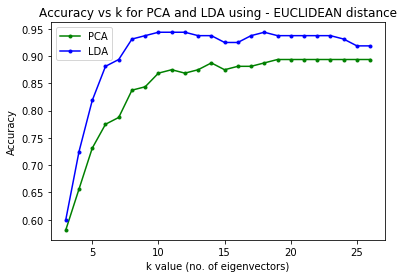

In [7]:
# plotting Accuracy vs k value
plt.plot(K,PCA_acc_euc,'.g-')
plt.plot(K,LDA_acc_euc,'.b-')
plt.xlabel('k value (no. of eigenvectors)')
plt.ylabel('Accuracy')
plt.legend(['PCA', 'LDA'])
plt.title('Accuracy vs k for PCA and LDA using - EUCLIDEAN distance')
plt.show()


# From the plot -
#      it is clear that using euclidean distance LDA gives more accurate results than PCA

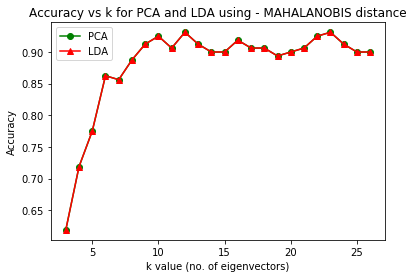

In [12]:
# plotting Accuracy vs k value
plt.plot(K,PCA_acc_man,'og-')
plt.plot(K,LDA_acc_man,'^r-')
plt.xlabel('k value (no. of eigenvectors)')
plt.ylabel('Accuracy')
plt.legend(['PCA', 'LDA'])
plt.title('Accuracy vs k for PCA and LDA using - MAHALANOBIS distance')
plt.show()


# From the plot -
#      it is clear that using mahanabolis distance LDA and PCA gives same results.
#      it may be because mahanabolis is a relativity based distance.

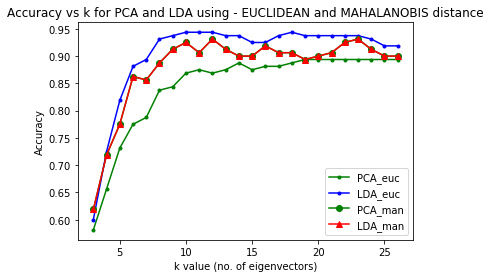

In [13]:
# plotting Accuracy vs k value
plt.plot(K,PCA_acc_euc,'.g-')
plt.plot(K,LDA_acc_euc,'.b-')
plt.plot(K,PCA_acc_man,'og-')
plt.plot(K,LDA_acc_man,'^r-')
plt.xlabel('k value (no. of eigenvectors)')
plt.ylabel('Accuracy')
plt.legend(['PCA_euc', 'LDA_euc', 'PCA_man', 'LDA_man'])
plt.title('Accuracy vs k for PCA and LDA using - EUCLIDEAN and MAHALANOBIS distance')
plt.show()


# From the plot -
#      it is clear that using euclidean distance - LDA gives more accurate results.
#      it is clear that using mahanabolis distance - LDA and PCA gives same results and are better than using euclidean dist. with PCA